Analyze the model performance

In [1]:
import numpy as np
import tensorflow as tf
from sklearn.metrics import f1_score, precision_score, recall_score
import requests
from sklearn import metrics
from matplotlib import pyplot as plt
import xml.etree.ElementTree as ET
import spacy
import pickle
from nltk.corpus import stopwords
from tensorflow.keras.preprocessing.sequence import pad_sequences
STOPWORDS = set(stopwords.words('english'))

Load the train and validation data and the model

In [2]:
train_padded = np.load('train_padded.npy')
validation_padded = np.load('validation_padded.npy')
train_abstracts = np.load('train_abstracts.npy')
validation_abstracts = np.load('validation_abstracts.npy')
training_label_seq = np.load('training_label_seq.npy')
validation_label_seq = np.load('validation_label_seq.npy')
validation_pmids = np.load('validation_pmids.npy')
train_pmids = np.load('train_pmids.npy')
loaded_model = tf.keras.models.load_model('saved_model/my_model_orphanet_final')

Predict the model results on the validation set and report on metrics

In [3]:
y_pred1 = loaded_model.predict(validation_padded)
y_pred = np.argmax(y_pred1, axis=1)

print(precision_score(validation_label_seq, y_pred , average="macro"))
print(recall_score(validation_label_seq, y_pred , average="macro"))
print(f1_score(validation_label_seq, y_pred , average="macro"))

0.8459980286087543
0.9373757336743485
0.8855156874583201


In [4]:
m = tf.keras.metrics.AUC()
_ = m.update_state(validation_label_seq, y_pred1[:,1])
m.result().numpy()

0.9670466

In [5]:
pmid_to_indices_val = {}
for i in range(len(validation_pmids)):
    pmid = validation_pmids[i]
    pmid_to_indices_val[pmid] = i

In [6]:
nlp = spacy.load('en_core_web_lg')
nlpSci = spacy.load("en_ner_bc5cdr_md")
nlpSci2 = spacy.load('en_ner_bionlp13cg_md')

## PubTypes

In [11]:
def isCaseReport(pmid):
    url = 'https://www.ebi.ac.uk/europepmc/webservices/rest/search?query=EXT_ID:'+str(pmid)+'&resulttype=core'
    r = requests.get(url)
    root = ET.fromstring(r.content)
    
    for child in root.iter('*'):
        if child.tag == 'pubType':
            if child.text == 'Case Reports' or child.text == 'case-report':
                return True
            
    return False

In [17]:
num_neg = 0
num_pos = 0
for i in range(len(validation_pmids)):
    pmid = validation_pmids[i]
    if isCaseReport(pmid):
        if y_pred[i] == 0:
            num_neg +=1
        else:
            print(pmid)
            num_pos += 1

28472977
32477803
32547795
30934652
32566533
31580529
32455177


KeyboardInterrupt: 

In [15]:
num_neg, num_pos

(1685, 17)

## Compare average predicted probability for false/true positives/negatives

In [25]:
fp_avg = 0
tp_avg = 0
fn_avg = 0
tn_avg = 0
num_fp = 0
num_tp = 0
num_tn = 0
num_fn = 0
for i in range(len(validation_pmids)):
    if y_pred[i] == 1 and validation_label_seq[i] == 0:
        fp_avg += y_pred1[i][1]
        num_fp += 1
    elif y_pred[i] == 1 and validation_label_seq[i] == 1:
        tp_avg += y_pred1[i][1]
        num_tp += 1
    elif y_pred[i] == 0 and validation_label_seq[i] == 1:
        fn_avg += y_pred1[i][1]
        num_fn += 1
    elif y_pred[i] == 0 and validation_label_seq[i] == 0:
        tn_avg += y_pred1[i][1]
        num_tn += 1

In [26]:
fp_avg/num_fp, tp_avg/num_tp, tn_avg/num_tn, fn_avg/num_fn

(0.8920402784760182,
 0.9663874708116055,
 0.022874982398464538,
 0.05630536054793213)

## AUROC

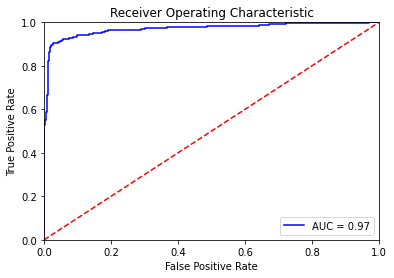

In [30]:
fpr, tpr, threshold = metrics.roc_curve(validation_label_seq, y_pred1[:,1])
roc_auc = metrics.auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.savefig('ROC')
plt.show()

In [28]:
plt.savefig('ROC')

<Figure size 432x288 with 0 Axes>